# ACE_krill dataset visual inspection of echogram and swarm detection

## Data description

Data collected during the Antarctic Circumnavigation Expedition (ACE) in 2017 using an EK80 echosounder running at a frequency of 200 kHz.

## Objective

Extracting the krill parameters

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
#import scipy.signal
#import skimage

## Import data



We import the csv file.

In [127]:
import ACE_box
import importlib
importlib.reload(ACE_box)

<module 'ACE_box' from '/home/benjamin/Documents/datascience/data jam days/scripts/ACE_box.py'>

In [139]:
data_path = '/home/benjamin/Documents/datascience/ACE/'
data_filename = 'ACE_-D20170207-T104031.sv.csv'
#data_filename = 'ACE_-D20170217-T200313.sv.csv'
#data_filename = 'ACE_-D20170217-T170649.sv.csv'
#data_filename = 'ACE_-D20170219-T060719.sv.csv'
#data_filename = 'ACE_-D20170210-T151429.sv.csv'
data_filename = 'ACE_-D20170209-T121539.sv.csv'
filename = data_path + data_filename
info_df,echogram,depth_data = ACE_box.extract_data(filename,150)

------------------------------
Data matrix size: (2693, 9145)
Start depth (in meters): 0.09278976
Stop depth (in meters): 499.8584359
Nb of pixels along depth axis: 2693
Depth per pixel (in meters): 0.185579519547
Echogram truncated to the first 150 meters (762 pixels).
Mean data value: -41.75 dB.
-----------------------------


In [4]:
np.mean(echogram)

-58.219230031533343

In [140]:
print('Start date:',info_df.Ping_date[0],info_df.Ping_time[0])
print('End date:',info_df.Ping_date[len(info_df.Ping_time)-1],info_df.Ping_time[len(info_df.Ping_time)-1])
print('Latitude',info_df.Latitude[5])
print('------------------------')
print('Filtering data...')
# Intermediate steps
data_rescale = ACE_box.fix_contrast(echogram)
data2 = ACE_box.remove_vertical_lines(data_rescale)
data_sub = ACE_box.substract_lin_meanovertime(data2)
data_mean = ACE_box.substract_meanovertime(data_sub)
#
denoised = ACE_box.filter_data(echogram)
print('Finding krill swarms...')
krillsignal,energy_fluctuation = ACE_box.krill_function(denoised,1)
print('Energy fluctuation:',energy_fluctuation)
swarm_echo_list = ACE_box.extract_krillchunks(krillsignal,denoised)
print("Nb of swarms found: ",len(swarm_echo_list))
print('Extracting swarm information...')
swarm_list = ACE_box.info_from_swarm_list(swarm_echo_list,echogram,info_df,depth_data,filename)
print('Done.')

Start date: 2017-02-09 12:15:39
End date: 2017-02-09 15:46:01
Latitude -71.11838935
------------------------
Filtering data...
Number of noisy pixels removed:  2293577
Number of noisy pixels removed:  2487034
Number of noisy pixels removed:  2293577
Number of noisy pixels removed:  2487034
Finding krill swarms...
Energy fluctuation: 1.84500406717
Nb of swarms found:  1135
Extracting swarm information...
Number of noisy pixels removed:  2044874
Number of noisy pixels removed:  1956722
Done.


<IPython.core.display.Javascript object>


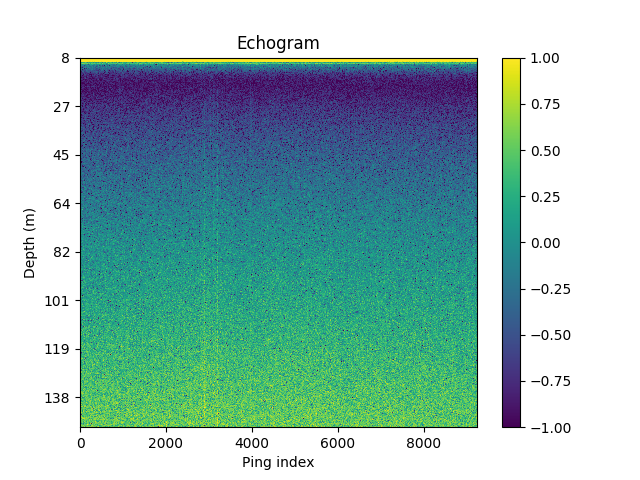

In [146]:
%matplotlib notebook
ACE_box.show_echogram(data2,depth_data)
plt.colorbar()

## Filtering processes

### Visualisation of the results of the first filtering processes

Number of noisy pixels removed:  2044874
Number of noisy pixels removed:  1956722


<IPython.core.display.Javascript object>


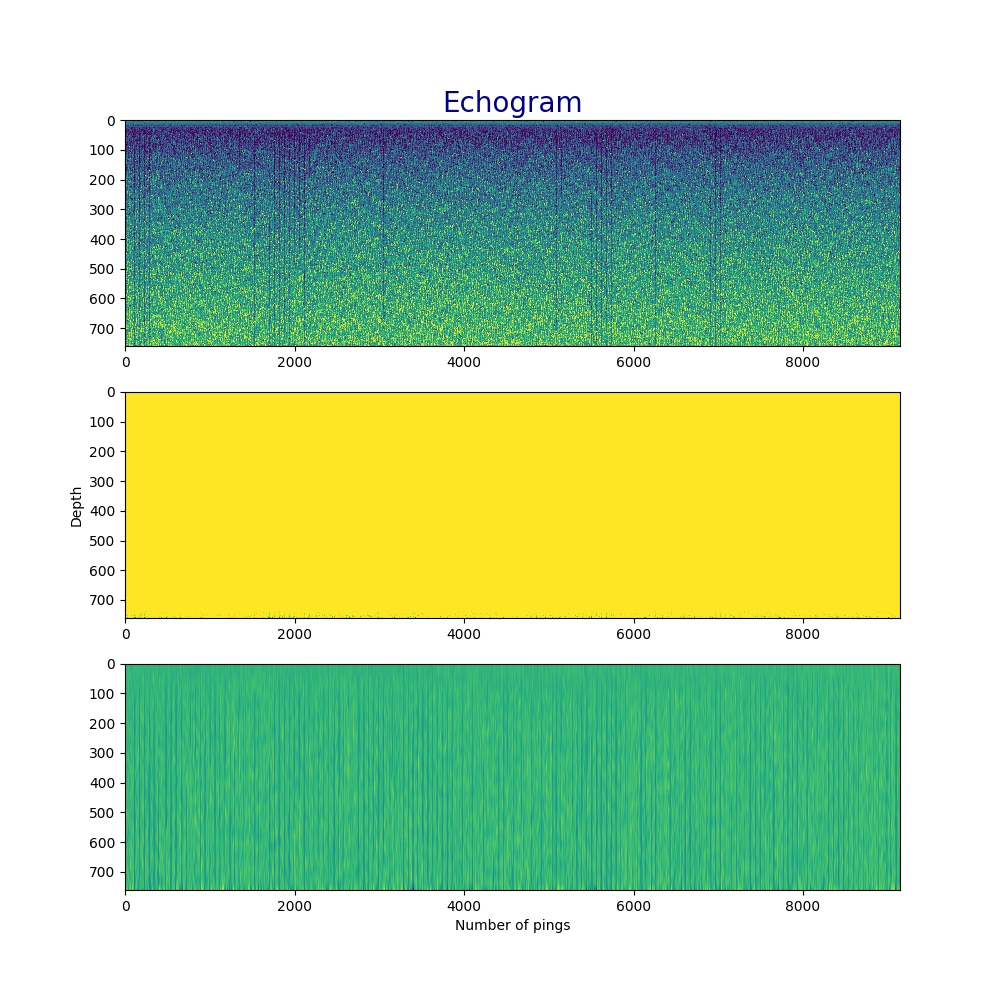

In [141]:
dataX = ACE_box.remove_vertical_lines(echogram)
echogram_rectif = ACE_box.remove_background_noise(dataX,depth_data)
%matplotlib notebook
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10)) 
ax1 = plt.subplot(3,1,1)
ax1.imshow(data_rescale,aspect='auto')
plt.title('Echogram',fontsize=20, color="darkblue")
ax2 = plt.subplot(3,1,2, sharex=ax1, sharey=ax1)
ax2.imshow(echogram_rectif,aspect='auto',vmin=-60,vmax=-40)
plt.ylabel('Depth')
ax3 = plt.subplot(3,1,3, sharex=ax1, sharey=ax1)
ax3.imshow(denoised,aspect='auto')
#ax3.imshow(databi[0:,:],aspect='auto')
plt.xlabel('Number of pings')
plt.show()

<IPython.core.display.Javascript object>


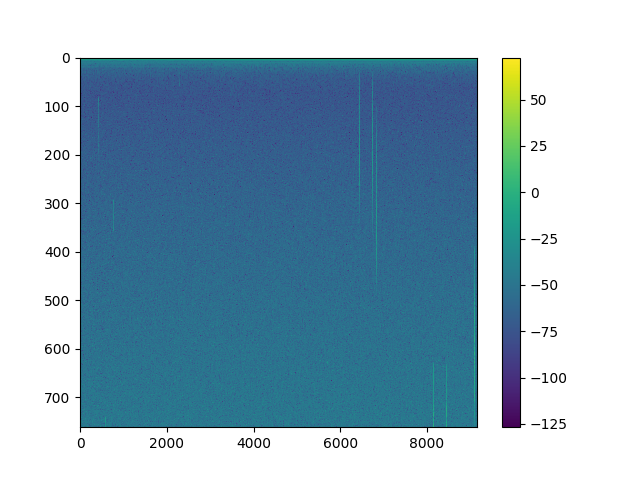

In [8]:
plt.figure()
plt.imshow(echogram, aspect='auto')
plt.colorbar()

<IPython.core.display.Javascript object>


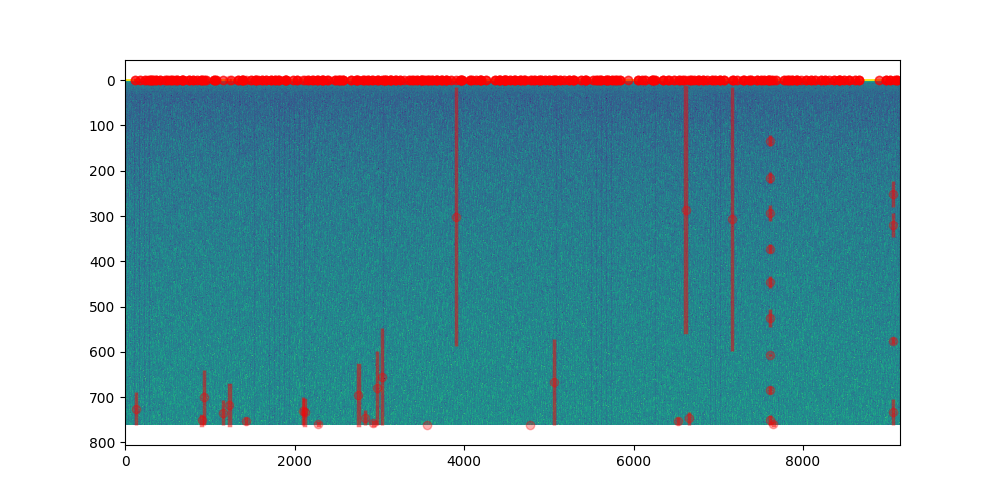

In [147]:
%matplotlib notebook
import matplotlib.patches as patches

D,L = [],[]
for swarm in swarm_list:
    D.append(swarm['depth_in_pixels'])
    L.append((swarm['ping_index_start']+swarm['ping_index_stop'])/2)

fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111, aspect='equal')
#fig1,ax1 = plt.subplots()
#ax1.imshow(data_trunc, aspect='auto')
ax1.imshow(echogram, aspect='auto')
ax1.scatter(L,D,c='r',alpha=0.3)
for swarm in swarm_list:
    height = swarm['height_in_pixels']
    y = swarm['depth_in_pixels'] - height/2
    x = swarm['ping_index_start']
    width = swarm['ping_index_stop'] - x
    rect = patches.Rectangle((x,y),width,height,fill=False,color='r',linewidth=2.5,alpha=0.5)
    # Create a Rectangle patch
    #rect = patches.Rectangle((50,100),40,30,linewidth=2.5,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax1.add_patch(rect)
plt.show()

In [12]:
import ACE_box
import importlib
importlib.reload(ACE_box)

<module 'ACE_box' from '/home/benjamin/Documents/datascience/data jam days/scripts/ACE_box.py'>

In [50]:
filtered_swarm_list = ACE_box.remove_bad_swarms(swarm_list) 

Initial nb of swarms: 81, final nb of swarms: 27.


In [143]:
filtered_swarm_list = [swarm for swarm in swarm_list if swarm['gradient']>3]

In [144]:
len(filtered_swarm_list)

18

In [145]:
for swarm in swarm_list:
    if swarm['depth_in_pixels']>0 and swarm['depth_in_pixels']<700:
        print(swarm['biomass_per_pixel_g'],swarm['mean_reflection_at_swarm_depth_g'],
          swarm['depth_in_pixels'],(swarm['ping_index_start']+swarm['ping_index_stop'])/2)

-35.0750361219 -33.5727625085 695.0 2754.0
-35.4293405572 -33.5280861517 679.5 2975.5
-34.9805123296 -33.5319553769 654.5 3033.5
-35.239363706 -35.2448399022 301.5 3907.0
-35.3838683814 -33.6141397254 666.5 5061.0
-35.2804002251 -35.2934928081 286.5 6614.0
-35.1059198565 -35.2141960165 307.5 7158.5
-35.3388882708 -35.4929243454 134.0 7612.5
-35.1518740083 -35.4063390599 215.0 7612.5
-34.6539022772 -35.257919724 293.0 7612.5
-33.4283224717 -35.0220430944 372.0 7612.5
-32.9861567911 -34.689375081 445.0 7612.5
-32.0666592952 -34.2428022148 525.0 7612.5
-28.4513486039 -33.7343954775 607.0 7612.5
-29.3005839488 -33.5399924273 684.0 7612.5
-35.0404902053 -35.3592417859 250.5 9057.5
-34.7963768869 -35.1789632373 320.0 9057.5
-33.0323786652 -33.9482518829 575.0 9057.5


<IPython.core.display.Javascript object>


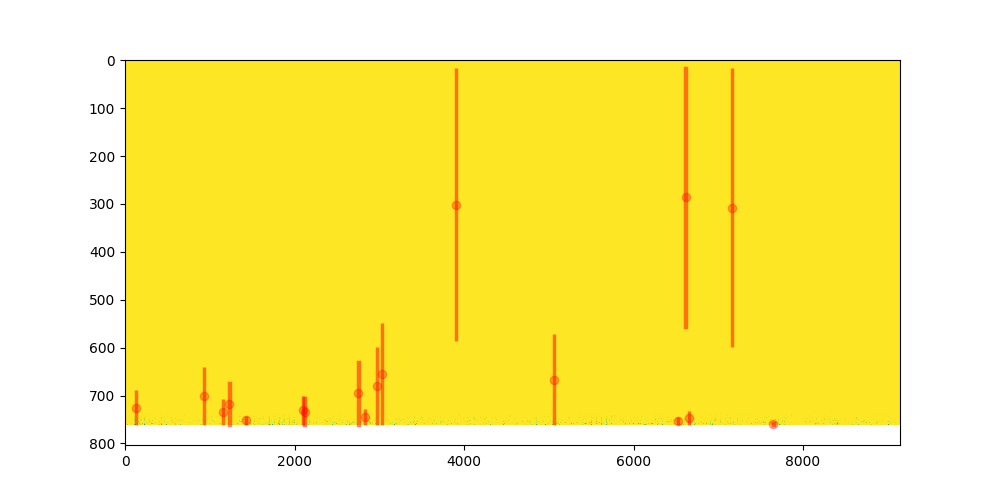

In [146]:
%matplotlib notebook
import matplotlib.patches as patches

D,L = [],[]
for swarm in filtered_swarm_list:
    D.append(swarm['depth_in_pixels'])
    L.append((swarm['ping_index_start']+swarm['ping_index_stop'])/2)

fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111, aspect='equal')
#fig1,ax1 = plt.subplots()
ax1.imshow(echogram_rectif, aspect='auto',vmin=-75,vmax=-40)
#ax1.imshow(denoised, aspect='auto')
ax1.scatter(L,D,c='r',alpha=0.3)
for swarm in filtered_swarm_list:
    height = swarm['height_in_pixels']
    y = swarm['depth_in_pixels'] - height/2
    x = swarm['ping_index_start']
    width = swarm['ping_index_stop'] - x
    rect = patches.Rectangle((x,y),width,height,fill=False,color='r',linewidth=2.5,alpha=0.5)
    # Create a Rectangle patch
    #rect = patches.Rectangle((50,100),40,30,linewidth=2.5,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax1.add_patch(rect)
plt.show()

In [15]:
np.mean(echogram_rectif,axis=1)

array([  7.24287012e+01,   7.24595924e+01,   7.25684056e+01,
         6.66738305e+01,   5.33925689e-02,  -1.51900497e+01,
        -2.37275980e+01,  -3.48595295e+01,  -4.11810423e+01,
        -4.48898651e+01,  -4.16018165e+01,  -4.10805766e+01,
        -4.51880215e+01,  -4.54151313e+01,  -4.60765194e+01,
        -4.74349682e+01,  -4.77057330e+01,  -4.79672229e+01,
        -4.80386597e+01,  -4.82693684e+01,  -4.88255632e+01,
        -4.91636577e+01,  -4.93412741e+01,  -4.93758716e+01,
        -4.94136657e+01,  -4.94685691e+01,  -4.95297449e+01,
        -4.96109475e+01,  -4.95872322e+01,  -4.95797328e+01,
        -4.96398356e+01,  -4.96942184e+01,  -4.97056933e+01,
        -4.97158950e+01,  -4.97406581e+01,  -4.97594713e+01,
        -4.97615941e+01,  -4.97574257e+01,  -4.97619958e+01,
        -4.97550062e+01,  -4.97738579e+01,  -4.97820803e+01,
        -4.97876579e+01,  -4.97895665e+01,  -4.97925719e+01,
        -4.97940409e+01,  -4.97966659e+01,  -4.97994539e+01,
        -4.98045672e+01,

In [27]:
a = np.mean(10**(echogram/10))

In [31]:
a

75887.903872220733

In [29]:
10*np.log10(a)

48.801725571840542

In [30]:
np.mean(echogram)

-58.219230031533343

In [36]:
a = [1]
b = [2]
a = a +b

In [37]:
a

[1, 2]

In [112]:
a= np.array([[1,2,3,4,5],[4,5,6,7,8]])

In [113]:
a

array([[1, 2, 3, 4, 5],
       [4, 5, 6, 7, 8]])

In [114]:
a[:,2:-2]

array([[3],
       [6]])

In [116]:
a[:,-2:]

array([[4, 5],
       [7, 8]])